Initial Mean Squared Error: 227.00483303012402
Cross-validation Mean Squared Error: -256.9275876737372
      age      fare  fare_trf  survived  survived_trf       fare_labels  \
491  21.0    7.2500       1.0         0           0.0       (0.0, 7.25]   
89   24.0    8.0500       3.0         0           0.0    (7.896, 8.158]   
178  30.0   13.0000       6.0         0           0.0      (10.5, 13.0]   
218  32.0   76.2917      13.0         1           0.0  (51.479, 76.292]   
393  23.0  113.2750      14.0         1           0.0  (108.9, 512.329]   

    survived_labels  
491             NaN  
89              NaN  
178             NaN  
218      (0.0, 1.0]  
393      (0.0, 1.0]  
Transformed Data Mean Squared Error: 175.20532149303367


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Cross-validation Mean Squared Error with Discretization: -207.0429015018843


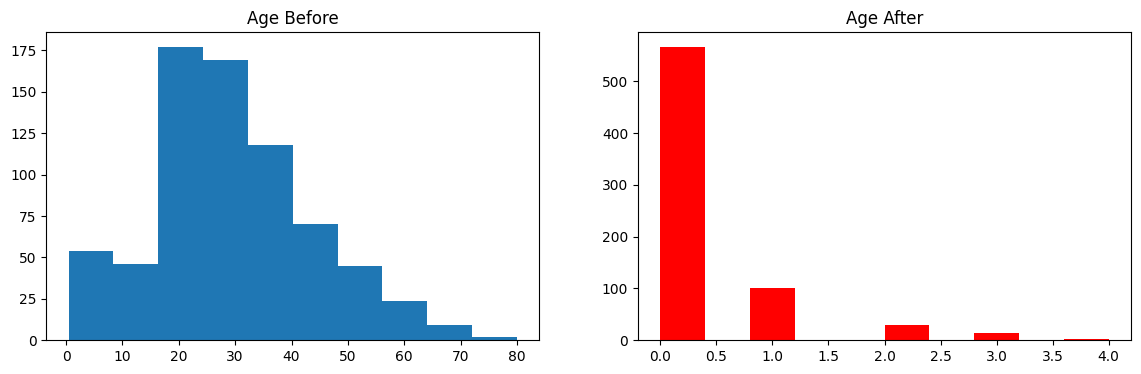

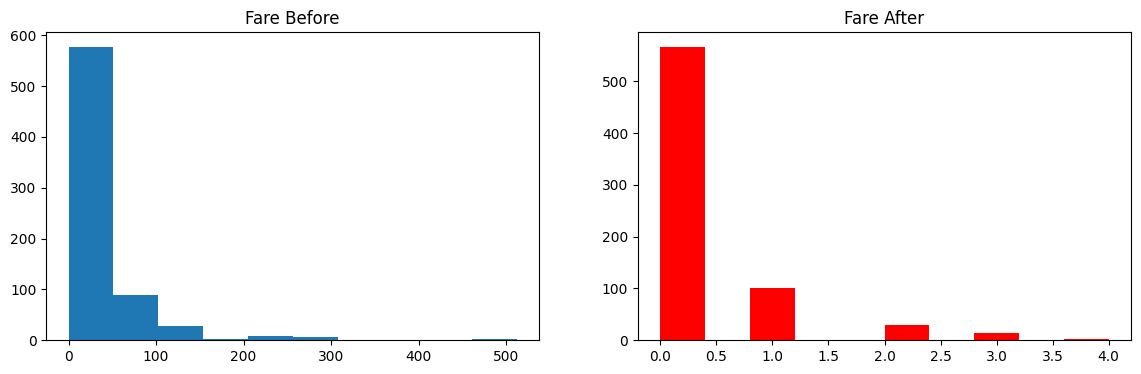

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

# Load the data
df = pd.read_csv('train.csv', usecols=['Age', 'Fare', 'Survived'])
df.dropna(inplace=True)

# Define features and target
X = df[['Fare', 'Survived']]
y = df['Age']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Evaluate the model
print(f"Initial Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Cross-validation Mean Squared Error: {np.mean(cross_val_score(regressor, X, y, cv=10, scoring='neg_mean_squared_error'))}")

# Discretize 'Fare' and 'Survived' using KBinsDiscretizer
kbin_fare = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')
kbin_survived = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='quantile')

# Apply the transformations
trf = ColumnTransformer([
    ('fare', kbin_fare, [0]),
    ('survived', kbin_survived, [1])
])

X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

# Visualize the transformation
output = pd.DataFrame({
    'age': y_train,
    'fare': X_train['Fare'],
    'fare_trf': X_train_trf[:, 0],
    'survived': X_train['Survived'],
    'survived_trf': X_train_trf[:, 1]
})

output['fare_labels'] = pd.cut(x=X_train['Fare'], bins=trf.named_transformers_['fare'].bin_edges_[0].tolist())
output['survived_labels'] = pd.cut(x=X_train['Survived'], bins=trf.named_transformers_['survived'].bin_edges_[0].tolist())
print(output.sample(5))

# Train and evaluate the regressor on transformed data
regressor.fit(X_train_trf, y_train)
y_pred2 = regressor.predict(X_test_trf)
print(f"Transformed Data Mean Squared Error: {mean_squared_error(y_test, y_pred2)}")

# Function to discretize and plot
def discretize(bins, strategy):
    kbin_fare = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)
    kbin_survived = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)

    trf = ColumnTransformer([
        ('fare', kbin_fare, [0]),
        ('survived', kbin_survived, [1])
    ])

    X_trf = trf.fit_transform(X)
    print(f"Cross-validation Mean Squared Error with Discretization: {np.mean(cross_val_score(DecisionTreeRegressor(), X_trf, y, cv=10, scoring='neg_mean_squared_error'))}")

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.hist(y)
    plt.title("Age Before")

    plt.subplot(122)
    plt.hist(X_trf[:, 0], color='red')
    plt.title("Age After")

    plt.show()

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.hist(X['Fare'])
    plt.title("Fare Before")

    plt.subplot(122)
    plt.hist(X_trf[:, 0], color='red')
    plt.title("Fare After")

    plt.show()

# Apply the discretize function
discretize(5, 'kmeans')
